In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *


rd = pd.read_csv('rides.csv', sep=',', skipinitialspace=True)
wt = pd.read_csv('weather.csv', sep=',', skipinitialspace=True)
rd.columns = [i.lower().replace(' ', '_') for i in rd.columns]
wt.columns = [i.lower().replace(' ', '_') for i in wt.columns]
rd.end_date = rd.end_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA)
rd.start_date = rd.start_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA)
wt.datetime = wt.datetime.astype(str).apply(lambda x: dt.datetime.strptime(x.replace(' ', 'T'), '%Y-%m-%dT%H:%M:%S') if len(x) == 19 else pd.NA)
rd.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
rd

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0
...,...,...,...,...,...,...,...,...,...,...
102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,Озерная,Юго-Восточный,Первомайская,Северо-Западный,3302.0,0
102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,Мичурина,Ленинский,Садовая,Заречный,4992.0,0
102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,Лермонтова,ленинский,Куйбышева,Центральный,2781.0,0
102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,Рябиновая,Северо-Западный,Энергетиков,Юго-Восточный,6466.0,0


In [6]:
wt

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,0,<NA>,°C,mm,km/h,km/h,%,min
1,1,2023-04-01 00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,3,2023-04-01 02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,4,2023-04-01 03:00:00,8.690246,0.3,55.44,21.94524,77,0
...,...,...,...,...,...,...,...,...
3668,3668,2023-08-31 19:00:00,16.940245,0,10.799999,1.08,89,1.4999998
3669,3669,2023-08-31 20:00:00,16.630245,0,11.159999,1.1384199,83,0
3670,3670,2023-08-31 21:00:00,17.080246,0.1,17.64,3.396233,82,0
3671,3671,2023-08-31 22:00:00,17.180244,0,21.599998,7.2359104,80,0


# Предобработка данных, очистка от выбросов и заполнение пропусков
#### Для начала на табличке без пропусков найдём средние значения времени поездки, скорости, расстояния и т.п. для дальнейшего заполнения пропусков

In [7]:
rd1 = rd.dropna()
rd1['start_date'] = pd.to_datetime(rd1['start_date'])
rd1['end_date'] = pd.to_datetime(rd1['end_date'])

rd1.loc[:, 'duration_sec'] = (rd1.loc[:, 'end_date'] - rd1.loc[:, 'start_date']).dt.total_seconds().astype(int)

<Axes: xlabel='speed'>

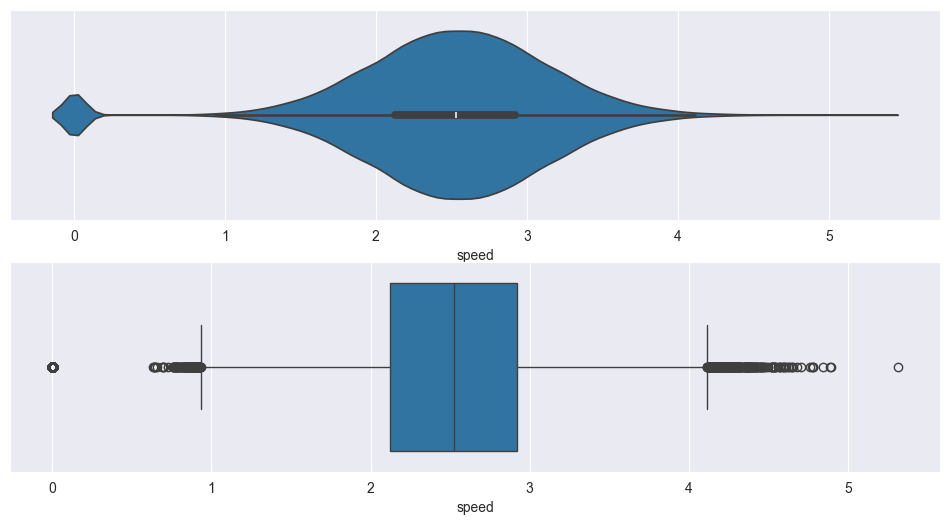

In [8]:
rd1.loc[:, 'speed'] = (rd1.loc[:, 'distance'] / rd1.loc[:, 'duration_sec']).astype(float)
rd1.loc[:, 'speed'] = rd1['speed'].where(rd1['speed'] <= 1000, pd.NA).dropna()  # находим скорость и ограничиваем экстремальные выбросы

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.violinplot(rd1.speed, orient='h', ax=axes[0])
sns.boxplot(rd1.speed, orient='h', ax=axes[1])

In [9]:
max(rd1.speed), min(rd1.speed)

(5.311881188118812, 0.0006653359946773121)

#### 5.31 м/с = 19.116 км/ч - вполне реальная величина скорости для самокатов, это намного ниже максимальной скорости большинства электросамокатов, а вот скорости, очень близкие к нулю - подозрительны, однако могут объясняться слишком большой продолжительностью поездки

<Axes: xlabel='duration_sec', ylabel='speed'>

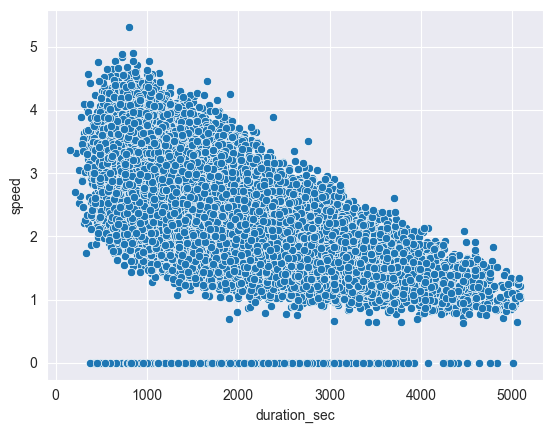

In [10]:
sns.scatterplot(data=rd1, x='duration_sec', y='speed')

<Axes: xlabel='distance', ylabel='duration_sec'>

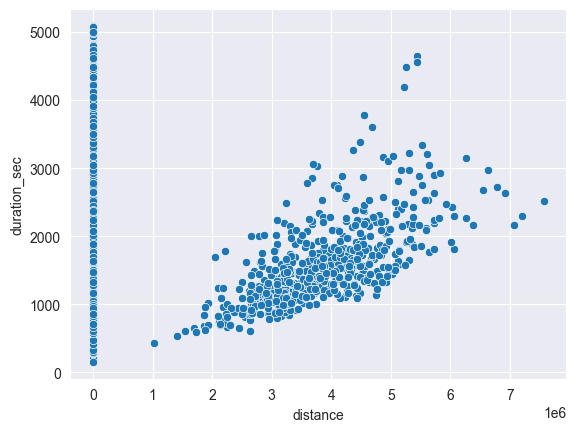

In [11]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [12]:
rd1.dropna(inplace=True)
if shapiro(rd1.speed)[1] >= 0.05 and shapiro(rd1.distance)[1] >= 0.05:
    print(pearsonr(rd1.speed, rd1.distance))
else:
    print(spearmanr(rd1.speed, rd1.distance))

SignificanceResult(statistic=0.08667645386462283, pvalue=6.876029134605452e-158)


In [72]:
rd1.nunique()

unnamed:_0        95045
id                95045
start_date        94240
end_date          94203
start_location      463
start_district       13
end_location        492
end_district         14
distance           5938
promo                 2
duration_sec       3794
speed             90522
dtype: int64

In [13]:
rd1

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed
0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0,1422,2.861463
1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0,1705,2.648094
2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0,2299,1.966072
3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0,1909,2.033002
4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0,1840,2.189674
...,...,...,...,...,...,...,...,...,...,...,...,...
102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,Озерная,Юго-Восточный,Первомайская,Северо-Западный,3302.0,0,1309,2.522536
102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,Мичурина,Ленинский,Садовая,Заречный,4992.0,0,2374,2.102780
102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,Лермонтова,ленинский,Куйбышева,Центральный,2781.0,0,1277,2.177760
102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,Рябиновая,Северо-Западный,Энергетиков,Юго-Восточный,6466.0,0,2783,2.323392
